In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import seaborn as sns
from scipy import stats
import os
import imageio
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D,Dropout,BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Dense, Activation, Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder


##load dataset

In [9]:
skin_df=pd.read_csv("/content/HAM10000_metadata.csv")

In [10]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
#label encoding to numerical values 
le=LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [12]:
skin_df['label']=le.transform(skin_df["dx"])
print(skin_df.sample(5))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


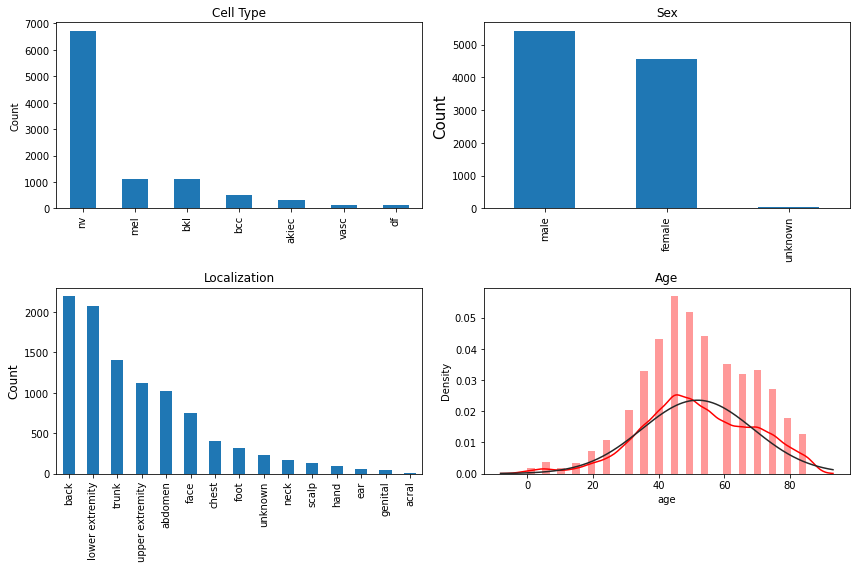

In [13]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [14]:
skin_df.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [15]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [16]:
#Balance data.

#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [17]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [18]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])


In [19]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [28]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/data', '*', '*.jpg'))}

In [29]:
SIZE=32
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [30]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = skin_df[skin_df['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(np.float)
    median_freq = np.median(counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight= estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i],":", classweight[i])

akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


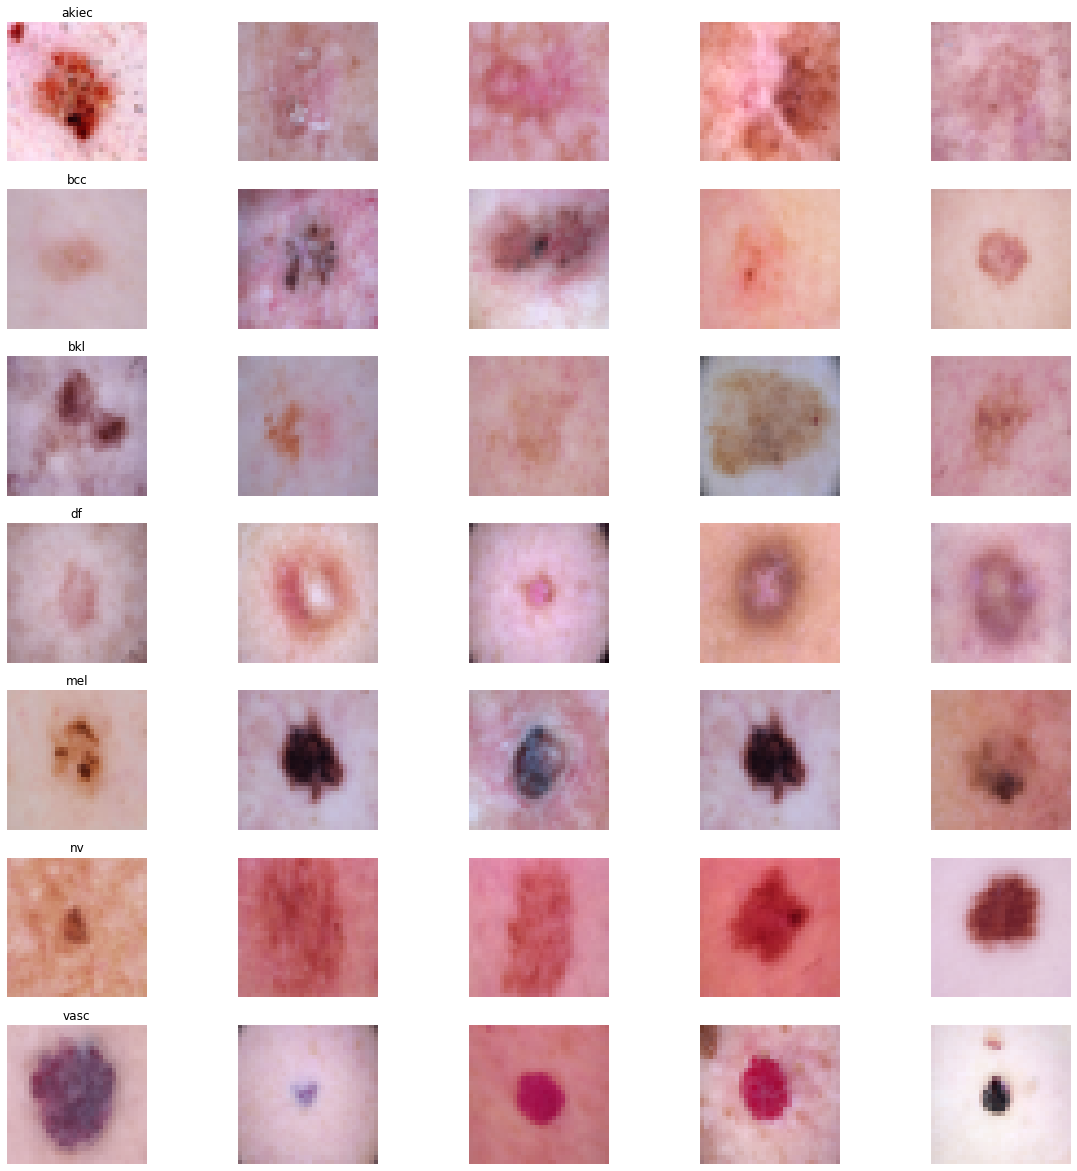

In [31]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
data_dir = os.getcwd() + "/HAM10000"

In [ ]:
!pip install imageio

In [34]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [35]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [43]:
df_4.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,4
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,4
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,4
1214,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,4
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,4


In [36]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 12s - loss: 1.9221 - acc: 0.1802 - val_loss: 1.8795 - val_acc: 0.2034 - 12s/epoch - 73ms/step
Epoch 2/50
165/165 - 1s - loss: 1.7657 - acc: 0.2659 - val_loss: 1.6939 - val_acc: 0.3006 - 900ms/epoch - 5ms/step
Epoch 3/50
165/165 - 1s - loss: 1.5883 - acc: 0.3577 - val_loss: 1.6056 - val_acc: 0.3269 - 865ms/epoch - 5ms/step
Epoch 4/50
165/165 - 1s - loss: 1.4864 - acc: 0.3928 - val_loss: 1.4239 - val_acc: 0.4000 - 867ms/epoch - 5ms/step
Epoch 5/50
165/165 - 1s - loss: 1.4372 - acc: 0.4137 - val_loss: 1.4214 - val_acc: 0.4286 - 880ms/epoch - 5ms/step
Epoch 6/50
165/165 - 1s - loss: 1.3576 - acc: 0.4446 - val_loss: 1.3659 - val_acc: 0.4709 - 877ms/epoch - 5ms/step
Epoch 7/50
165/165 - 1s - loss: 1.3309 - acc: 0.4823 - val_loss: 1.3710 - val_acc: 0.4389 - 1s/epoch - 6ms/step
Epoch 8/50
165/165 - 1s - loss: 1.3041 - acc: 0.4960 - val_loss: 1.2740 - val_acc: 0.5040 - 876ms/epoch - 5ms/step
Epoch 9/50
165/165 - 1s - loss: 1.2745 - acc: 0.4964 - val_loss: 1.2769 - val_acc: 

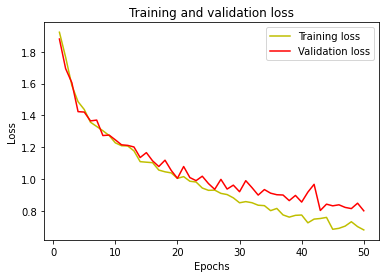

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

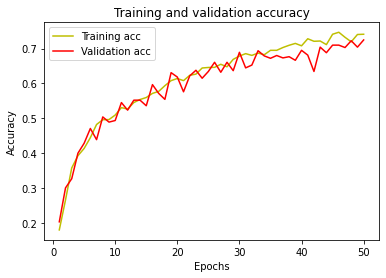

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


28/28 [==============================] - 0s 3ms/step


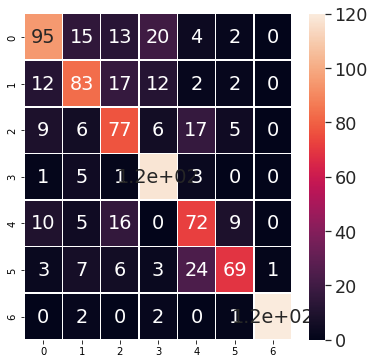

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

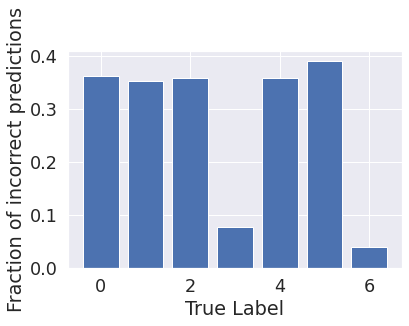

In [41]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
